Accelerating VQEs with quantum natural gradient
===============================================

::: {.meta}
:property=\"og:description\": Accelerating variational quantum
eigensolvers using quantum natural gradients in PennyLane.
:property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets/qng_example.png>
:::

::: {.related}
tutorial\_vqe A brief overview of VQE
tutorial\_quantum\_natural\_gradient Quantum natural gradient
:::

*Authors: Maggie Li, Lana Bozanic, Sukin Sim --- Posted: 06 November
2020. Last updated: 29 August 2023.*

This tutorial showcases how one can apply quantum natural gradients
(QNG) to accelerate the optimization step of the Variational Quantum
Eigensolver (VQE) algorithm. We will implement two small examples:
estimating the ground state energy of a single-qubit VQE problem, which
we can visualize using the Bloch sphere, and the hydrogen molecule.

Before going through this tutorial, we recommend that readers refer to
the
`QNG tutorial </demos/tutorial_quantum_natural_gradient>`{.interpreted-text
role="doc"} and `VQE tutorial </demos/tutorial_vqe>`{.interpreted-text
role="doc"} for overviews of quantum natural gradient and the
variational quantum eigensolver algorithm, respectively. Let\'s get
started!

Single-qubit VQE example
------------------------

The first step is to import the required libraries and packages:


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp

In [3]:
from setup_env import setup_environment

setup_environment()

For this simple example, we consider the following single-qubit
Hamiltonian: $\sigma_x + \sigma_z.$

We define the device:


In [4]:
dev = qml.device("default.qubit", wires=1)

For the variational ansatz, we use two single-qubit rotations, which the
user may recognize from a previous
`tutorial </demos/tutorial_qubit_rotation>`{.interpreted-text
role="doc"} on qubit rotations.


In [6]:
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)

init_params = pnp.array([3.97507603, 3.00854038], requires_grad=True)

We then define our cost function which supports the computation of
block-diagonal or diagonal approximations to the Fubini-Study metric
tensor. This tensor is a crucial component for optimizing with quantum
natural gradients.


(<Figure size 500x200 with 1 Axes>, <Axes: >)


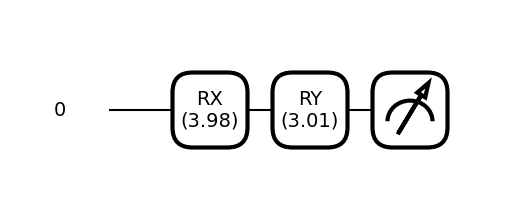

In [7]:
coeffs = [1, 1]
obs = [qml.PauliX(0), qml.PauliZ(0)]

H = qml.Hamiltonian(coeffs, obs)

@qml.qnode(dev)
def cost_fn(params):
    circuit(params)
    return qml.expval(H)

print(qml.draw_mpl(cost_fn, decimals=2)(init_params))

In [8]:
mt_fn = qml.metric_tensor(cost_fn, approx="block-diag")
tensor = mt_fn(init_params)
tensor

tensor([[0.25      , 0.        ],
        [0.        , 0.11299722]], requires_grad=True)

To analyze the performance of quantum natural gradient on VQE
calculations, we set up and execute optimizations using the
`GradientDescentOptimizer` (which does not utilize quantum gradients)
and the `QNGOptimizer` that uses the block-diagonal approximation to the
metric tensor.

To perform a fair comparison, we fix the initial parameters for the two
optimizers.


We will carry out each optimization over a maximum of 500 steps. As was
done in the VQE tutorial, we aim to reach a convergence tolerance of
around $10^{-6}.$ We use a step size of 0.01.


In [9]:
max_iterations = 500
conv_tol = 1e-06
step_size = 0.01

First, we carry out the VQE optimization using the standard gradient
descent method.


We then repeat the process for the optimizer employing quantum natural
gradients:


In [10]:
opt = qml.QNGOptimizer(stepsize=step_size, approx="block-diag")

params = init_params

qngd_param_history = [params]
qngd_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params, metric_tensor_fn=mt_fn)
    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    # Compute energy
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = pnp.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 0.51052556 Ha,  Convergence parameter = 0.06664604 Ha
Iteration = 20,  Energy = -0.90729965 Ha,  Convergence parameter = 0.05006082 Ha
Iteration = 40,  Energy = -1.35504644 Ha,  Convergence parameter = 0.00713113 Ha
Iteration = 60,  Energy = -1.40833787 Ha,  Convergence parameter = 0.00072399 Ha
Iteration = 80,  Energy = -1.41364035 Ha,  Convergence parameter = 0.00007078 Ha
Iteration = 100,  Energy = -1.41415774 Ha,  Convergence parameter = 0.00000689 Ha

Final value of the energy = -1.41420585 Ha
Number of iterations =  117


### QNG with Superop

(<Figure size 500x300 with 1 Axes>, <Axes: >)


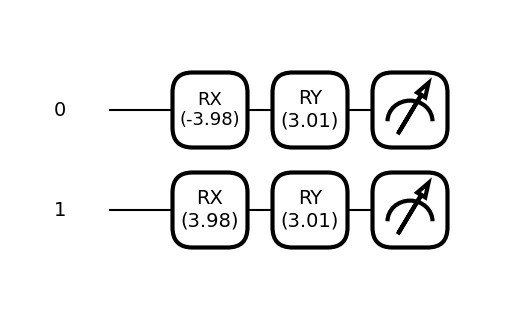

In [11]:
from src.superop import superoperator

dev_super = qml.device("default.qubit", wires=2)

@qml.qnode(dev_super)
@superoperator()
def qnode_superop(params):
    circuit(params)
    return qml.state()


print(qml.draw_mpl(qnode_superop, decimals=2)(init_params))

In [12]:
from src.hsip import HSIP

meas = HSIP(H, [0])  # Hilbert-Schmidt inner product

def cost_superop(params):
    sv = qnode_superop(params)
    return meas(sv)

In [13]:
from src.hsmt import hsmt

hsmt_fn = hsmt(qnode_superop)
metric_tensor = hsmt_fn(init_params)
metric_tensor.real

tensor([[2.50000000e-01, 1.28417717e-18],
        [1.28417717e-18, 1.12997219e-01]], requires_grad=True)

In [14]:
opt = qml.QNGOptimizer(stepsize=step_size)

params = init_params

qngd_supop_param_history = [params]
qngd_supop_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(
        cost_superop, params.real, metric_tensor_fn=hsmt_fn
    )
    qngd_supop_param_history.append(params)
    qngd_supop_cost_history.append(prev_energy)

    # Compute energy
    energy = cost_superop(params)

    # Calculate difference between new and old energies
    conv = pnp.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 0.51052556 Ha,  Convergence parameter = 0.06664604 Ha
Iteration = 20,  Energy = -0.90729965 Ha,  Convergence parameter = 0.05006082 Ha
Iteration = 40,  Energy = -1.35504644 Ha,  Convergence parameter = 0.00713113 Ha
Iteration = 60,  Energy = -1.40833787 Ha,  Convergence parameter = 0.00072399 Ha
Iteration = 80,  Energy = -1.41364035 Ha,  Convergence parameter = 0.00007078 Ha
Iteration = 100,  Energy = -1.41415774 Ha,  Convergence parameter = 0.00000689 Ha

Final value of the energy = -1.41420585 Ha
Number of iterations =  117


Visualizing the results
=======================

For single-qubit examples, we can visualize the optimization process in
several ways.

For example, we can track the energy history:


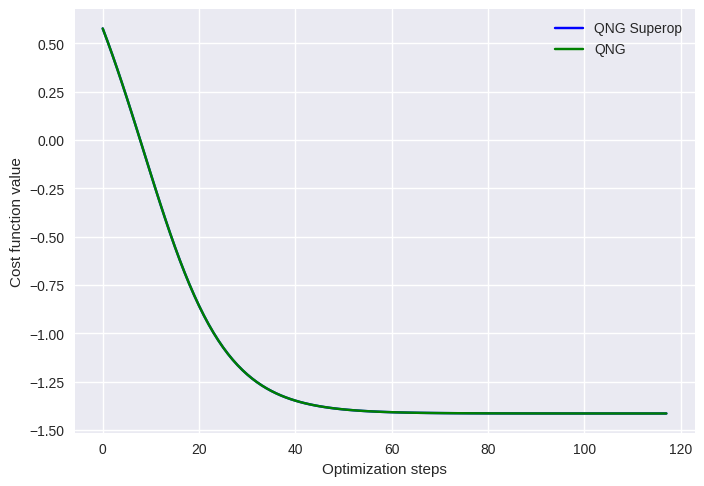

In [15]:
plt.style.use("seaborn-v0_8")
plt.plot(qngd_supop_cost_history, "b", label="QNG Superop")
plt.plot(qngd_cost_history, "g", label="QNG")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Or we can visualize the optimization path in the parameter space using a
contour plot. Energies at different grid points have been pre-computed,
and they can be downloaded by clicking
`here<../_static/demonstration_assets/vqe_qng/param_landscape.npy>`{.interpreted-text
role="download"}.


## Single Qubit noisy

(<Figure size 600x200 with 1 Axes>, <Axes: >)


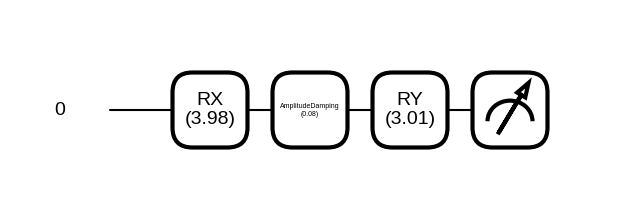

In [25]:
def noisy_circuit(params):
    qml.RX(params[0], wires=0)
    qml.AmplitudeDamping(0.08, wires=0)
    qml.RY(params[1], wires=0)

dev_noisy = qml.device("default.mixed", wires=1)
@qml.qnode(dev_noisy, diff_method="parameter-shift")
def noisy_cost_fn(params):
    noisy_circuit(params)
    return qml.expval(H)

print(qml.draw_mpl(noisy_cost_fn, decimals=2)(init_params))

In [26]:
noisy_mt_fn = qml.metric_tensor(noisy_cost_fn, approx="block-diag")
noisy_tensor = noisy_mt_fn(init_params)
noisy_tensor

array([[0.25      , 0.        ],
       [0.        , 0.12395744]])

In [27]:
opt = qml.QNGOptimizer(stepsize=step_size, approx="block-diag")

params = init_params

qngd_param_history = [params]
qngd_cost_history = []

max_iterations = 500
conv_tol = 1e-06
step_size = 0.01

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(noisy_cost_fn, params, metric_tensor_fn=noisy_mt_fn)
    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    # Compute energy
    energy = noisy_cost_fn(params)

    # Calculate difference between new and old energies
    conv = pnp.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 0.41931199 Ha,  Convergence parameter = 0.04300576 Ha
Iteration = 20,  Energy = -0.42301597 Ha,  Convergence parameter = 0.04394230 Ha
Iteration = 40,  Energy = -1.03461083 Ha,  Convergence parameter = 0.01523665 Ha
Iteration = 60,  Energy = -1.16703714 Ha,  Convergence parameter = 0.00224163 Ha
Iteration = 80,  Energy = -1.18524022 Ha,  Convergence parameter = 0.00029122 Ha
Iteration = 100,  Energy = -1.18759062 Ha,  Convergence parameter = 0.00003751 Ha
Iteration = 120,  Energy = -1.18789397 Ha,  Convergence parameter = 0.00000486 Ha

Final value of the energy = -1.18793044 Ha
Number of iterations =  136


(<Figure size 600x300 with 1 Axes>, <Axes: >)


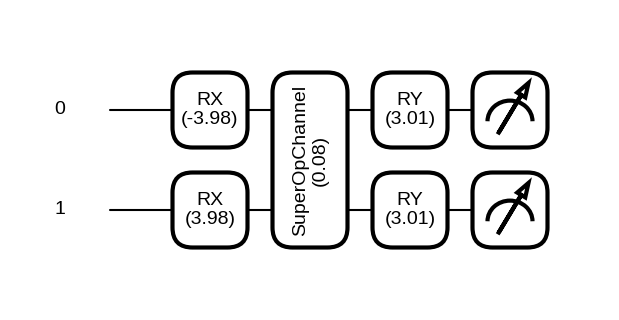

In [28]:
@qml.qnode(dev_super)
@superoperator()
def noisy_qnode_superop(params):
    noisy_circuit(params)
    return qml.state()


print(qml.draw_mpl(noisy_qnode_superop, decimals=2)(init_params))

In [29]:
def noisy_cost_superop(params):
    sv = noisy_qnode_superop(params)
    return meas(sv)

In [30]:
noisy_hsmt_fn = hsmt(noisy_qnode_superop)
metric_tensor = noisy_hsmt_fn(init_params)
metric_tensor.real

tensor([[ 2.19916595e-01, -1.59307965e-18],
        [-1.59307965e-18,  7.25001624e-02]], requires_grad=True)

In [31]:
opt = qml.QNGOptimizer(stepsize=step_size)

params = init_params

qngd_supop_param_history = [params]
qngd_supop_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(
        noisy_cost_superop, params.real, metric_tensor_fn=noisy_hsmt_fn
    )
    qngd_supop_param_history.append(params)
    qngd_supop_cost_history.append(prev_energy)

    # Compute energy
    energy = noisy_cost_superop(params)

    # Calculate difference between new and old energies
    conv = pnp.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 0.39628855 Ha,  Convergence parameter = 0.06602920 Ha
Iteration = 20,  Energy = -0.89164210 Ha,  Convergence parameter = 0.03458820 Ha
Iteration = 40,  Energy = -1.15926820 Ha,  Convergence parameter = 0.00362472 Ha
Iteration = 60,  Energy = -1.18528809 Ha,  Convergence parameter = 0.00033439 Ha
Iteration = 80,  Energy = -1.18769094 Ha,  Convergence parameter = 0.00003113 Ha
Iteration = 100,  Energy = -1.18791581 Ha,  Convergence parameter = 0.00000294 Ha

Final value of the energy = -1.18793210 Ha
Number of iterations =  110


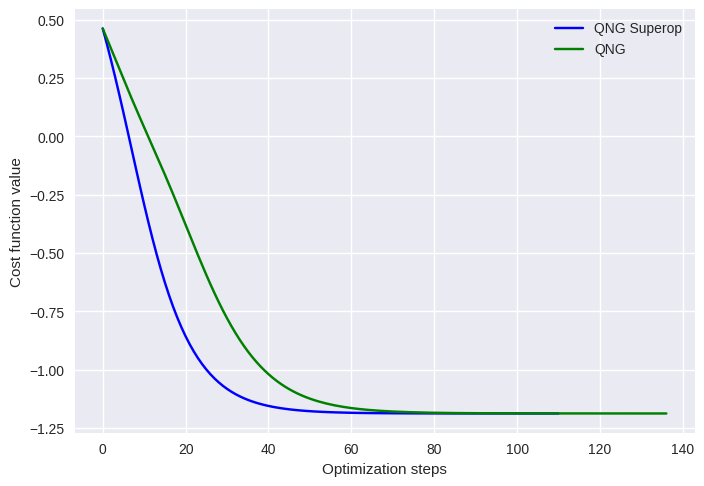

In [32]:
plt.style.use("seaborn-v0_8")
plt.plot(qngd_supop_cost_history, "b", label="QNG Superop")
plt.plot(qngd_cost_history, "g", label="QNG")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Here, the blue regions indicate states with lower energies, and the red
regions indicate states with higher energies. We can see that the
`QNGOptimizer` takes a more direct route to the minimum in larger
strides compared to the path taken by the `GradientDescentOptimizer`.

Lastly, we can visualize the same optimization paths on the Bloch sphere
using routines from [QuTiP](http://qutip.org/). The result should look
like the following:

![](/_static/demonstration_assets/vqe_qng/opt_paths_bloch.png){.align-center
width="50.0%"}

where again the black markers and line indicate the path taken by the
`QNGOptimizer`, and the green markers and line indicate the path taken
by the `GradientDescentOptimizer`. Using this visualization method, we
can clearly see how the path using the `QNGOptimizer` tightly \"hugs\"
the curvature of the Bloch sphere and takes the shorter path.